# Refresher

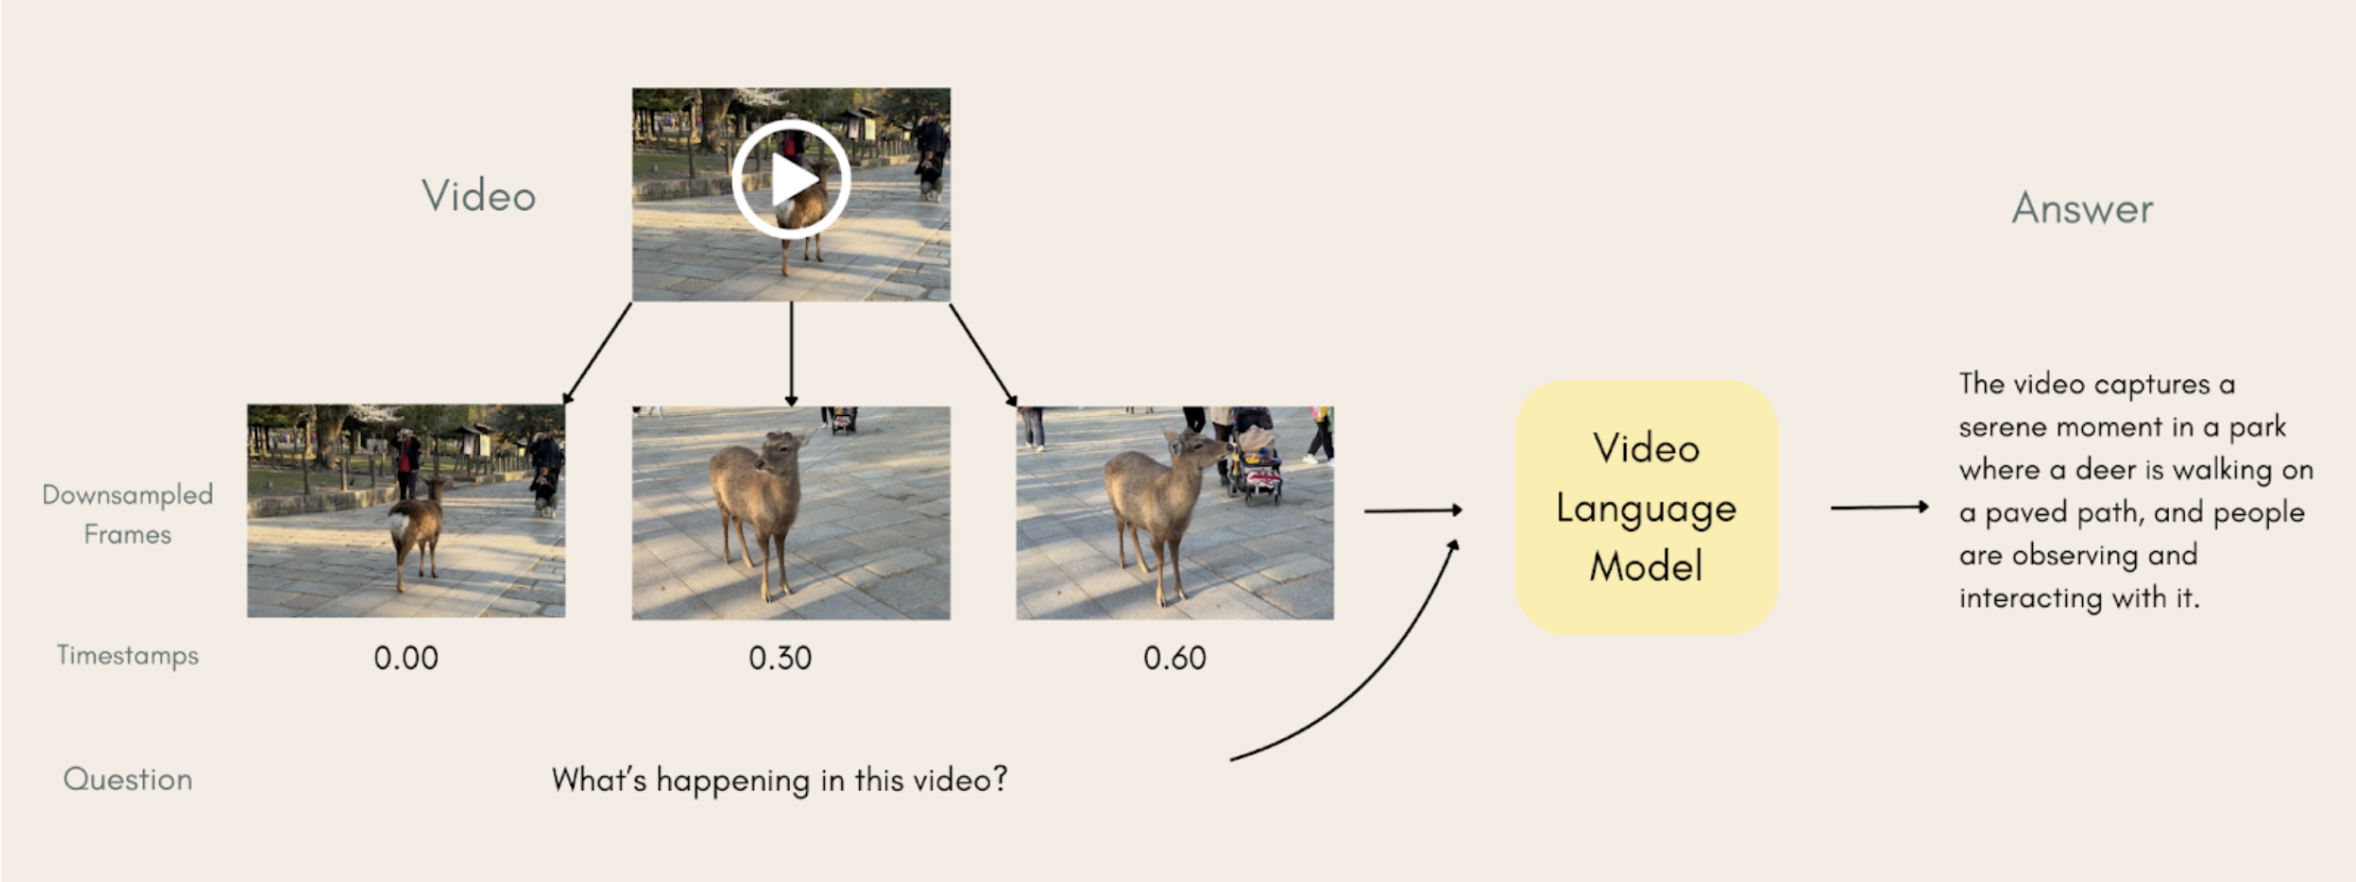

In [ ]:
# VideoRAG

# converts videos to embeddings with InternVideo2
# those frames without text are supplemented via Whisper
# then the embeddings are stored in a vector database


# Video-RAG
# try to add to vector database these info as well?
# For Optical Character Recognition (OCR): EasyOCR (to read text visible in the video frames).
# For Audio Transcription: Whisper (to convert speech to text).
# For Object Detection: APE (to identify objects and their locations in keyframes).
# For Text Encoding: Contriever (to create embeddings for the RAG step).



# multimodal retriever architectures (can this be stored in a vector database?)
# Document Screenshot Embedding (DSE, MCDSE)
# ColBERT-like models (ColPali, ColQwen2, ColSmolVLM)

In [ ]:
# VideoRAG (https://github.com/starsuzi/VideoRAG)
# query + retrieval via InternVideo2
# this is going to be input to LlaVA-Video-7B to generate a response



"""
LVLMs list (name, params, release data, training data specs (like fps, etc), manufacturer, model card link)
    sharegpt4video-8b (https://huggingface.co/Lin-Chen/sharegpt4video-8b)
        can use ShareCaptionerVideo for captionining videos (https://huggingface.co/Lin-Chen/ShareCaptioner-Video)
    VideoLLaMA3-7B (https://huggingface.co/DAMO-NLP-SG/VideoLLaMA3-7B)
        
    Tarsier2-Recap-7b (https://huggingface.co/omni-research/Tarsier2-Recap-7b)

    Kimi (https://huggingface.co/moonshotai/Kimi-VL-A3B-Instruct)
    qwen2.5-VL  (https://huggingface.co/Qwen/Qwen2.5-VL-7B-Instruct)
    MiniCPM-o-2_6 (https://huggingface.co/openbmb/MiniCPM-o-2_6)
    VideoChat-Flash  (https://huggingface.co/OpenGVLab/VideoChat-Flash-Qwen2-7B_res448)
    VideoChat-R1 (https://huggingface.co/OpenGVLab/VideoChat-R1_7B)
        has a thinking version (https://huggingface.co/OpenGVLab/VideoChat-R1-thinking_7B)
        can use caption model (https://huggingface.co/OpenGVLab/VideoChat-R1_7B_caption)
    InternVideo2_5_Chat_8B (https://huggingface.co/OpenGVLab/InternVideo2_5_Chat_8B)
    InternVL3-8B (https://huggingface.co/OpenGVLab/InternVL3-8B)

    ### IMPORTANT: before usibng the open-source models, check github and hf for best param values
    

    Gemini 2.5 Pro (Reasoning On) Video Input (use during parsing)
    Gemini 2.5 Flash (Reasoning On) Video Input (selected model for now, but test if response generation latency is acceptable)
    Gemini 2.5 Flash-Lite (No available reasoning) Video Input
"""

"""
    1. Data to Embedding to Vector DB
        use a multimodal embedding model that can handle text, images, and videos
            like InternVideo2 or 2.5?, and store the embeddings in a vector database
            so they exist in the same vector space (all text, images, and videos) [one single, unified, shared embedding space]

            for videos, its chopped to n frames
                a batch of frames, like 8, is transformed to appropriate pixel size, and divides into smaller patches, 
                    the patches are converted to a sequence of embedding vectors, and add position embeddings
                    the final sequence of embedding vectors is then used to generate the video embeddings via the model

        the question is how to generate embeddings for these modalities using the same model
            2 ways (find embedding model vs use existing model encoder):

            maybe find the best text and image embedding models, and then use them to generate embeddings for the text and images in the videos
                to ensure that the embeddings are in the same vector space, use a model that can handle all image and text,
                    since the video is just a sequence of images and text, the model should be able to handle that

            OR find a way to use the encoder of Intervideo2.5/ InternVL3 to generate embeddings for the text and images in the videos
                the retriever model must have a very strong video encoder

                like load model -> encoder = model.encoder()
            
            why didnt they use the decoder from InternVideo2.5 to generate responses?
                its not really trained for this, the QWENVL they used is more suited for this task    

    2. Model Loading
        use xxxx (internvl3-8B for now?)

    3. Base Model RAG
        generate responses with the base model, using the embeddings from the vector database using similarity search

    4. Create a basic webapp 
        use gradio or other framework? for more flexibility comapred to gradio and streamlit

    5. Test if running


"""




"""
    do manual benchmarking of the models in DGX
    compare the performance of different models on various tasks
    use the results to select the best model for each task

    create a report with the results and recommendations
    create a script to automate the benchmarking process
    

    OR find existing leaderboards online (like HuggingFace, Papers with Code, etc) and use them to select the best model for each task
    

    LEADERBOARDS:
        https://huggingface.co/spaces/opencompass/openvlm_video_leaderboard


"""

---

The large tensor created by the preprocessing functions (`load_image`, `load_video`) is the **input data** for the model, not the final embedding.

Think of it like this:

1.  **Raw Data:** `my_image.jpg`
2.  **Preprocessing (`load_image`)**: Converts the image into a large `pixel_values` tensor. This tensor represents the image in a way the model can understand (normalized, tiled, etc.).
3.  **Encoding (Model Forward Pass)**: You must feed this `pixel_values` tensor **through the model** to generate the embedding.
    *   `visual_features = model.vision_model(pixel_values)`
    *   `image_embeds = model.mlp1(visual_features)`
4.  **Pooling**: The `image_embeds` tensor will still have multiple vectors (one for each image patch). You need to aggregate them into a single vector for the entire image, usually by taking the mean.
    *   `final_embedding = image_embeds.mean(dim=1)`
5.  **Storage**: This `final_embedding` (a single vector per image/video/text) is what you store in the vector database.

---

### `build_transform(input_size)`

This function creates a standard image transformation pipeline.
1.  **`T.Lambda(...)`**: Ensures the image is in RGB color format.
2.  **`T.Resize(...)`**: Resizes the image to a square of `input_size` x `input_size` using bicubic interpolation, which is a high-quality resizing method.
3.  **`T.ToTensor()`**: Converts the PIL Image into a PyTorch tensor, scaling pixel values from `[0, 255]` to `[0.0, 1.0]`.
4.  **`T.Normalize(...)`**: Normalizes the tensor's pixel values with the standard ImageNet mean and standard deviation. This is a crucial step as the vision model was pretrained on ImageNet, and it expects images to be in this normalized distribution.

### `dynamic_preprocess(...)`

This is the key function for handling images of various aspect ratios without excessive distortion. Instead of forcing every image into a single square, it intelligently splits the image into a grid of squares.

1.  **`find_closest_aspect_ratio(...)`**: This helper function determines the best grid layout (e.g., 1x2, 2x2, 3x4) to represent the original image by finding a target aspect ratio that is closest to the original.
2.  **Resizing**: The image is resized to fit this optimal grid layout. For example, for a wide image, it might be resized to `448 x 896` pixels to fit a 1x2 grid of `448x448` patches.
3.  **Cropping/Tiling**: The resized image is then cropped into a series of square tiles (e.g., two `448x448` tiles from the `448x896` image). This preserves local details better than squishing the entire image.
4.  **`use_thumbnail`**: If `True`, it also creates a single, standard `448x448` thumbnail of the whole image and adds it to the list of tiles. This provides the model with both a high-resolution, tiled view and a low-resolution, global view of the image.
5.  **Return Value**: It returns a list of PIL Image objects, each being a tile or the thumbnail.

### `load_image(...)`

This function orchestrates the entire image preprocessing workflow.
1.  It opens the image file.
2.  It calls `dynamic_preprocess` to get the list of image tiles.
3.  It applies the `build_transform` to each tile.
4.  It stacks all the transformed tiles into a single PyTorch tensor, ready to be fed into the model.

### `get_video_index(...)` & `load_video(...)`

These functions adapt the image preprocessing for video.
1.  **`get_video_index`**: Instead of processing every frame, this function samples frames uniformly from the video. It divides the video into `num_segments` and picks one frame from the middle of each segment.
2.  **`load_video`**: It uses `decord` to read the video file. For each frame index selected by `get_video_index`, it extracts the frame as an image.
3.  Each extracted frame is then processed just like a static image using `dynamic_preprocess` and `build_transform`.
4.  Finally, it concatenates all the processed frame tensors into a single large tensor representing the video.



---

Visual Frames are like raw, silent photographs. They have no inherent concept of time. We must add a timestamp to them (via positional embeddings) to give them that missing dimension.


Timestamped Subtitles are like a narrator's script that already says, "At the two-second mark, the hero opens the door." The timing information is already an integral part of the language. You don't need to add a separate timestamp because the description itself contains the time.

Video: Add mathematical (sinusoidal) positional embeddings to the visual features.

Text: Encode the timestamps directly and naturally within the text itself.

Example input: "[00:02-00:05] The circle continues its motion."

# Libraries

In [10]:
import os

# IMPORTANT: This must be done BEFORE importing torch
# This makes only GPU device 6 visible to this script.
os.environ["CUDA_VISIBLE_DEVICES"] = "5,6,7"

import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel, BitsAndBytesConfig

import numpy as np
from PIL import Image
from decord import VideoReader, cpu
import torchvision.transforms as T
from torchvision.transforms.functional import InterpolationMode


import fitz  # PyMuPDF
from PIL import Image
import io



import chromadb
import uuid


import math
import pprint

# Now, PyTorch only sees one GPU, and its index is 0
# So, the standard .cuda() will work and will point to the original GPU 6
print(f"Is CUDA available? {torch.cuda.is_available()}")
print(f"Current device index: {torch.cuda.current_device()}") # Should print 0
print(f"Device name: {torch.cuda.get_device_name(0)}") # Will show the name of GPU 6
try:
    # This will fail because only devices 0, 1, and 2 (original GPUs 5, 6, 7) are visible
    print(torch.cuda.get_device_name(3))
except Exception as e:
    print("\nAs expected, trying to access another GPU (e.g., index 3) fails:")
    print(e)

Is CUDA available? True
Current device index: 0
Device name: NVIDIA A100-SXM4-40GB

As expected, trying to access another GPU (e.g., index 3) fails:
Invalid device id


In [2]:
# explore langchain, langgraph, llamaindex, llamagraph?
# crewAI, AG2
# neo4j

# Data to Embedding to VDB

## Embedding Model Setup

In [3]:
### EMBEDDING MODEL

# Configure for 4-bit quantization
# quantization_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_compute_dtype=torch.bfloat16 # Use bfloat16 for computations
# )

# Configure for 8-bit quantization
quantization_config = BitsAndBytesConfig(
    load_in_8bit=True,
)

path = "OpenGVLab/InternVL3-8B"
model = AutoModel.from_pretrained(
    path,
    torch_dtype=torch.bfloat16,  # Use bfloat16 for better performance
    quantization_config=quantization_config,
    low_cpu_mem_usage=True,
    # use_flash_attention_2=True,
    trust_remote_code=True,
    device_map="auto").eval()

FlashAttention2 is not installed.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
tokenizer = AutoTokenizer.from_pretrained(path, trust_remote_code=True, use_fast=False)

In [5]:
model
# model.vision_model.encoder
# model.language_model.model

InternVLChatModel(
  (vision_model): InternVisionModel(
    (embeddings): InternVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): InternVisionEncoder(
      (layers): ModuleList(
        (0): InternVisionEncoderLayer(
          (attn): InternAttention(
            (qkv): Linear8bitLt(in_features=1024, out_features=3072, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear8bitLt(in_features=1024, out_features=1024, bias=True)
          )
          (mlp): InternMLP(
            (act): GELUActivation()
            (fc1): Linear8bitLt(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear8bitLt(in_features=4096, out_features=1024, bias=True)
          )
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (

In [6]:
help(model)

Help on InternVLChatModel in module transformers_modules.OpenGVLab.InternVL3-8B.24dc81a234a6e1901f3314eeadaa2813f2b78038.modeling_internvl_chat object:

class InternVLChatModel(InternVLChatModel, transformers.generation.utils.GenerationMixin)
 |  InternVLChatModel(config: transformers_modules.OpenGVLab.InternVL3-8B.24dc81a234a6e1901f3314eeadaa2813f2b78038.configuration_internvl_chat.InternVLChatConfig, vision_model=None, language_model=None, use_flash_attn=True)
 |
 |  Method resolution order:
 |      InternVLChatModel
 |      InternVLChatModel
 |      transformers.modeling_utils.PreTrainedModel
 |      torch.nn.modules.module.Module
 |      transformers.modeling_utils.EmbeddingAccessMixin
 |      transformers.modeling_utils.ModuleUtilsMixin
 |      transformers.utils.hub.PushToHubMixin
 |      transformers.integrations.peft.PeftAdapterMixin
 |      transformers.generation.utils.GenerationMixin
 |      transformers.generation.continuous_batching.ContinuousMixin
 |      builtins.object


In [7]:
### VIDEO DATA

# --- Preprocessing Functions (from Hugging Face) ---

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

def load_image(image_file, input_size=448, max_num=12):
    image = Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

def get_index(bound, fps, max_frame, first_idx=0, num_segments=32):
    if bound:
        start, end = bound[0], bound[1]
    else:
        start, end = -100000, 100000
    start_idx = max(first_idx, round(start * fps))
    end_idx = min(round(end * fps), max_frame)
    seg_size = float(end_idx - start_idx) / num_segments
    frame_indices = np.array([
        int(start_idx + (seg_size / 2) + np.round(seg_size * idx))
        for idx in range(num_segments)
    ])
    return frame_indices

def load_video(video_path, bound=None, input_size=448, max_num=1, num_segments=32):
    vr = VideoReader(video_path, ctx=cpu(0), num_threads=1)
    max_frame = len(vr) - 1
    fps = float(vr.get_avg_fps())

    pixel_values_list, num_patches_list = [], []
    transform = build_transform(input_size=input_size)
    frame_indices = get_index(bound, fps, max_frame, first_idx=0, num_segments=num_segments)
    for frame_index in frame_indices:
        img = Image.fromarray(vr[frame_index].asnumpy()).convert('RGB')
        img = dynamic_preprocess(img, image_size=input_size, use_thumbnail=True, max_num=max_num)
        pixel_values = [transform(tile) for tile in img]
        pixel_values = torch.stack(pixel_values)
        num_patches_list.append(pixel_values.shape[0])
        pixel_values_list.append(pixel_values)
    pixel_values = torch.cat(pixel_values_list)
    return pixel_values, num_patches_list


## Example Model Queries

In [6]:
# set the max number of tiles in `max_num`
pixel_values = load_image('/data/students/christian/capstone_project/multimodal-rag/Test Dataset/Test Dataset Image/Maya-3D-Models.jpg'
                          , max_num=12).to(torch.bfloat16).cuda()
generation_config = dict(max_new_tokens=1024, do_sample=True)

# pure-text conversation (纯文本对话)
question = 'Hello, who are you?'
response, history = model.chat(tokenizer, None, question, generation_config, history=None, return_history=True)
print(f'User: {question}\nAssistant: {response}')

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
/data/students/christian/miniconda3/envs/capstone_project/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


User: Hello, who are you?
Assistant: Hello! I'm an AI assistant here to help you with any questions or tasks you have. How can I assist you today?


In [7]:
question = 'Can you tell me a story?'
response, history = model.chat(tokenizer, None, question, generation_config, history=history, return_history=True)
print(f'User: {question}\nAssistant: {response}')

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: Can you tell me a story?
Assistant: Of course! Here's a short story for you:

---

**The Enchanted Garden**

In a small, quiet town nestled among lush green hills, there was a garden that sparkled with magic. Legend had it that the garden was enchanted by an old woman named Elara, who lived beside it. Elara was known for her kind heart and her ability to communicate with nature. She spent her days planting flowers, tending to the trees, and nurturing the soil, always humming a gentle melody that attracted butterflies and birds.

Every evening, as the sun dipped below the horizon, a gentle breeze carried the scent of of blooming roses and fragrant jasmine throughout the town. The townsfolk would whisper about a hidden entrance to the enchanted garden, guarded by an ancient oak tree that shimmered with a soft, ethereal glow. But only those with pure hearts and a curious mind could find it.

One sunny afternoon, a young girl named Lily came upon the garden by chance. While wandering

In [8]:
# single-image single-round conversation (单图单轮对话)
question = '<image>\nPlease describe the image shortly.'
response = model.chat(tokenizer, pixel_values, question, generation_config)
print(f'User: {question}\nAssistant: {response}')

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: <image>
Please describe the image shortly.
Assistant: The image is an informational graphic about Autodesk Maya 3D models, illustrating concepts such as Maya 3D Models, Digital Three Dimensional Representation, and Autodesk Maya, and their how they relate to 3D Modeling, Animation, and Rendering Industry. 

Key Points:

1. **Maya 3D Models**:
   - Shown as digital, three-dimensional representations of of real-world objects.
   
2. **Digital Three Dimensional Representation**:
   - Illustrated with hands manipulating simple geometric shapes like cubes and spheres.

3. **Autodesk Maya**:
   - Displayed with its logo, labeled as an application created tools used for 3D modeling, animation, and rendering.

4. **Processes with Autodesk Maya**:
   - **3D Modeling**: Depicted showing a person working in a 3D modeling software environment.
   - **Animation**: Shown with a person creating poses for a character.
   - **Rendering Industry**: Illustrated with a person adjusting settings in a

In [9]:
# single-image multi-round conversation (单图多轮对话)
question = '<image>\nPlease describe the image in detail.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config, history=None, return_history=True)
print(f'User: {question}\nAssistant: {response}')

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: <image>
Please describe the image in detail.
Assistant: The image is an informative illustration about "Maya 3D Models." It consists of several interconnected segments that outline the context and usage of Autodesk Maya:

1. **Title**: "Maya 3D Models" is prominently displayed at the top.

2. **Key Components**: 
   - On the left, figures labeled "Maya 3D Models" depict 3D characters.
   - In the center, "Digital Three Dimensional Representation" includes icons of 3D shapes and hands interacting with them, indicating the creation of digital 3D objects.
   - On the right, the Autodesk Maya logo is accompanied by "Created with" and "Autodesk Maya" showing the software used for creation.

3. **Functions**:
   - Below these components, three main applications of of Maya are labeled and illustrated:
     - **3D Modeling**: Depicted with a person working on a 3D modeling software interface.
     - **Animation**: Shown with an animated character in motion, representing the animation cap

In [10]:
question = 'Please write a poem according to the image.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config, history=history, return_history=True)
print(f'User: {question}\nAssistant: {response}')

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: Please write a poem according to the image.
Assistant: In the realm of digital realms, where shapes come to life,
Two figures stand tall, with designs that grow tight.
In the heart of creation, where cubes and spheres blend,
A tale unfolds of art, where imagination never ends.

Beneath soft blue skies of crafted from code,
Hands sculpt and stretch, molds softly unfold.
Digital echoes of of visions and dreams,
In 3D realms, worlds convene and extremes be themes.

With lines and with curves, they weave stories untold,
In the glow of of screens, creativity abounds and bold.
Animation springs, as motions dance freely,
In the realms of of Maya, each frame carries glee.

From model to marvel, in each software’s embrace,
Artists soar, in every hue and space.
In rendering's skies, where light and color align,
Transforming craft to creation, with each click, a new shine.

In this vast creative expanse, where Autodesk reigns,
Models rise, to tell tales transcending our range.
From start to

In [11]:
# multi-image multi-round conversation, combined images (多图多轮对话，拼接图像)
pixel_values1 = load_image('/data/students/christian/capstone_project/multimodal-rag/Test Dataset/Test Dataset Image/Importance-of-3D-Models-in-Maya.webp'
                           , max_num=12).to(torch.bfloat16).cuda()
pixel_values2 = load_image('/data/students/christian/capstone_project/multimodal-rag/Test Dataset/Test Dataset Image/Maya-3D-Models.jpg'
                           , max_num=12).to(torch.bfloat16).cuda()
pixel_values = torch.cat((pixel_values1, pixel_values2), dim=0)

question = '<image>\nDescribe the two images in detail.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config,
                               history=None, return_history=True)
print(f'User: {question}\nAssistant: {response}')

question = 'What are the similarities and differences between these two images.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config,
                               history=history, return_history=True)
print(f'User: {question}\nAssistant: {response}')

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: <image>
Describe the two images in detail.
Assistant: The image is an infographic about the importance and applications of of 3D models creation using Autodesk Maya. It has the following sections and images:

1. **Top Section (Central Focus)**
   - Heading: "Importance of of 3D Models in Maya."
   - The image features three key components branching from the main heading:
     - **Maya 3D Models**: Illustrated with animated human figures standing confidently.
     - **Digital Three Dimensional Representation**: Shown with hands creating a cube and sphere, indicating the modeling process.
     - **Autodesk Maya**: Represented by the Autodesk Maya logo with a stylized representation of a 3D model and the text "Created with MAYA."

2. **Below the Header (Connected to Central Components)**
   - **3D Modeling**: 
     - Depicts an illustration of a seated person working on a computer, displaying 3D modeling software interfaces and objects.
   - **Animation**: 
     - Shows a person cre

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: What are the similarities and differences between these two images.
Assistant: The infographic and the section where you describe the two images share several aspects:

### Similarities:
1. **Subject Matter**:
   - Both convey information about Autodesk Maya and its applications. The infographic illustrates how Maya is used in 3D modeling, animation, and rendering.

2. **Layout**:
   - Both images use a structured, visual approach with icons and graphics to explain concepts clearly.

3. **Illustrations**:
   - Each section contains illustrations showing people working with computer software and 3D models creation.

4doth cover are designed for educational purposes, likely to inform viewers about Autodesk Maya.

### Differences:
1. **Content Focus**:
   - The infographic is broad, covering multiple aspects (3D Modeling, Animation, Rendering Industry) and uses connecting lines to display relationships.
   - Your description focuses on two separate components of the infographic: 3D 

In [12]:
# multi-image multi-round conversation, separate images (多图多轮对话，独立图像)
pixel_values1 = load_image('/data/students/christian/capstone_project/multimodal-rag/Test Dataset/Test Dataset Image/Importance-of-3D-Models-in-Maya.webp'
                           , max_num=12).to(torch.bfloat16).cuda()
pixel_values2 = load_image('/data/students/christian/capstone_project/multimodal-rag/Test Dataset/Test Dataset Image/Maya-3D-Models.jpg'
                           , max_num=12).to(torch.bfloat16).cuda()
pixel_values = torch.cat((pixel_values1, pixel_values2), dim=0)
num_patches_list = [pixel_values1.size(0), pixel_values2.size(0)]

question = 'Image-1: <image>\nImage-2: <image>\nDescribe the two images in detail.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config,
                               num_patches_list=num_patches_list,
                               history=None, return_history=True)
print(f'User: {question}\nAssistant: {response}')

question = 'What are the similarities and differences between these two images.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config,
                               num_patches_list=num_patches_list,
                               history=history, return_history=True)
print(f'User: {question}\nAssistant: {response}')

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: Image-1: <image>
Image-2: <image>
Describe the two images in detail.
Assistant: Image-2: The image is an infographic titled "Maya 3D Models" and explains the significance and applications of of Autodesk Maya software. It depicts two children standing confidently, labeled "Maya 3D Models". The central part shows an illustration with hands gesturing towards basic 3D shapes, indicating "Digital Three Dimensional Representation". To the right, there is the Autodesk Maya logo with the text "Created with MAYA". The image outlines three main uses of of Autodesk Maya: "3D Modeling", "Animation", and "Rendering Industry". Under "3D Modeling", an illustration shows a person working on a computer with multiple screens showing wireframe models elements. "Animation" illustration shows a person creating poses of, indicating animation work. Finally, "Rendering Industry" illustration features a person with animated figures, symbolizing rendering processes. The overall bottom right corner has the

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: What are the similarities and differences between these two images.
Assistant: Image differ in the layout and the specific details they focus on. Image-2 emphasizes the applications and components of Maya 3D models creation, such as "3D Modeling," "Animation," and "Rendering Industry." It also illustrates the user interface and related activities workflow. Image-1, in contrast, highlights broader importance themes of 3D models usage, including "Visual Representation," "Realismim and Immerion," and "Flexibility and Adaptability," within "Marketing and Advertising," "Collaboration Workflows," and "Visualization and Prototyping." Both share common elements like the Autodesk Maya logo and mention aspects of 3D modeling, but the first focuses more on usage importance, while the second is on the creation and process aspects.


In [13]:
# batch inference, single image per sample (单图批处理)
pixel_values1 = load_image('/data/students/christian/capstone_project/multimodal-rag/Test Dataset/Test Dataset Image/Importance-of-3D-Models-in-Maya.webp'
                           , max_num=12).to(torch.bfloat16).cuda()
pixel_values2 = load_image('/data/students/christian/capstone_project/multimodal-rag/Test Dataset/Test Dataset Image/Maya-3D-Models.jpg'
                           , max_num=12).to(torch.bfloat16).cuda()
num_patches_list = [pixel_values1.size(0), pixel_values2.size(0)]
pixel_values = torch.cat((pixel_values1, pixel_values2), dim=0)

questions = ['<image>\nDescribe the image in detail.'] * len(num_patches_list)
responses = model.batch_chat(tokenizer, pixel_values,
                             num_patches_list=num_patches_list,
                             questions=questions,
                             generation_config=generation_config)
for question, response in zip(questions, responses):
    print(f'User: {question}\nAssistant: {response}')

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: <image>
Describe the image in detail.
Assistant: The image is an infographic about the "Importance of of 33D Models in Maya" with a circular flow design, divided into four main sections that loop from one to another: 

11. The top section (in teal) is labeled "Animation and Storytellinging" with an icon of a play screen or video camera symbol, indicating this area's focus on animation.

The left section (in dark grey) is labeled "Virtual Worlds and Simulations," featuring an icon of a person in a virtual environment, pointing to its role in creating virtual spaces.

The bottom section (also dark grey) is titled "Visualization and Prototyping," with an icon of a hand using a tool, symbolizing the use of 33D models models for designing and conceptualizing.

The right section (again in teal) contains three labels stacked vertically:

- The top one is named "Flexibility and Adaptability" with an icon showing arrows.
- The middle section is named "Realism and Immersion" with a human f

In [16]:
video_path = '/data/students/christian/capstone_project/multimodal-rag/Test Dataset/Test Dataset Video/Basic UV Mapping Maya Tutorial with Planar Projections.mp4'
pixel_values, num_patches_list = load_video(video_path, num_segments=8, max_num=1)
pixel_values = pixel_values.to(torch.bfloat16).cuda()
video_prefix = ''.join([f'Frame{i+1}: <image>\n' for i in range(len(num_patches_list))])
question = video_prefix + 'What is the video about?'
# Frame1: <image>\nFrame2: <image>\n...\nFrame8: <image>\n{question}
response, history = model.chat(tokenizer, pixel_values, question, generation_config,
                               num_patches_list=num_patches_list, history=None, return_history=True)
print(f'User: {question}\nAssistant: {response}')

question = 'Describe this video in detail.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config,
                               num_patches_list=num_patches_list, history=history, return_history=True)
print(f'User: {question}\nAssistant: {response}')


/data/students/christian/miniconda3/envs/capstone_project/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: Frame1: <image>
Frame2: <image>
Frame3: <image>
Frame4: <image>
Frame5: <image>
Frame6: <image>
Frame7: <image>
Frame8: <image>
What is the video about?
Assistant: The video is a tutorial on how to use a software. It shows the interface of the software and how to use it.


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: Describe this video in detail.
Assistant: Sure, in the first first second, we see a screenshot from a video game. It looks like a grey grid on a computer screen. Then, in the second and third seconds, we see a screenshot from a video being shown on a computer screen. It appears to show a game board with different colored rectangles, a blue square, a grid on the back of a refrigerator, blue, yellow, and white controls, and a red and green symbol. In the fourth second, we see another screenshot of a game being shown on a computer screen. This one shows a game with blue and yellow controls, a white and green keyboard, a red and green sticker, and a purple computer tower. Finally, in the last second, we see a third screenshot from a different video game. This one shows a picture of a donut with a green background, a green and white key, a picture of a bus, a blue square hanging from a ceiling, and a cartoon character.


## Embedding Generation

In [19]:
# --- Image Preprocessing ---
# Load the image, which is dynamically split into tiles.
# The result is a tensor of shape [num_tiles, channels, height, width].
image_path = '/data/students/christian/capstone_project/multimodal-rag/Test Dataset/Test Dataset Image/Importance-of-3D-Models-in-Maya.webp'
pixel_values = load_image(image_path, max_num=12).to(torch.bfloat16).cuda()
print(f"Input pixel values shape (num_tiles, C, H, W): {pixel_values.shape}")

# --- Feature Extraction ---
# Extract patch-level features for all tiles in a single batch.
# The model returns a tensor of shape [num_tiles, num_patches_per_tile, feature_dim].
with torch.no_grad():
    features = model.extract_feature(pixel_values=pixel_values)
print(f"Extracted patch features shape: {features.shape}")

# --- Pooling to a Single Vector ---
# To get a single embedding for the entire image, we perform a two-step mean pooling:
# 1. Average across the patches (dim=1) to get a single vector per tile.
# 2. Average across the tiles (dim=0) to get a single vector for the whole image.
# This results in a tensor of shape [feature_dim].
with torch.no_grad():
    image_embedding = features.mean(dim=[0, 1])
print(f"Pooled image embedding shape: {image_embedding.shape}")

# --- Prepare for ChromaDB ---
# Convert the final embedding to the format required by ChromaDB:
# a float32 NumPy array on the CPU.
chromadb_ready_embedding = image_embedding.detach().cpu().to(torch.float32).numpy()

print(f"\nChromaDB-ready embedding shape: {chromadb_ready_embedding.shape}")
print(f"ChromaDB-ready embedding dtype: {chromadb_ready_embedding.dtype}")

Input pixel values shape (num_tiles, C, H, W): torch.Size([3, 3, 448, 448])
Extracted patch features shape: torch.Size([3, 256, 3584])
Pooled image embedding shape: torch.Size([3584])

ChromaDB-ready embedding shape: (3584,)
ChromaDB-ready embedding dtype: float32


In [18]:
# --- Text Embedding Generation ---
# Define the text to be embedded
text_to_embed = 'Hello, who are you?'

# Tokenize the text and move to the appropriate device
input_ids = tokenizer(text_to_embed, return_tensors='pt').input_ids.cuda()

# Generate embeddings within a no_grad context for efficiency
with torch.no_grad():
    # Get token-level embeddings from the language model
    token_embeddings = model.language_model.model.embed_tokens(input_ids)
    
    # Pool the token embeddings to get a single document-level embedding
    # We do this by averaging across the sequence length dimension (dim=1)
    # .squeeze(0) removes the batch dimension, resulting in a 1D tensor
    document_embedding = token_embeddings.mean(dim=1).squeeze(0)

print(f"Original token embeddings shape: {token_embeddings.shape}")
print(f"Pooled document embedding shape: {document_embedding.shape}")

# --- Prepare for ChromaDB ---
# Convert the final embedding to a CPU numpy array, which is the format ChromaDB expects
chromadb_ready_embedding = document_embedding.detach().cpu().to(torch.float32).numpy()

print(f"ChromaDB-ready embedding shape: {chromadb_ready_embedding.shape}")
print(f"ChromaDB-ready embedding dtype: {chromadb_ready_embedding.dtype}")

Original token embeddings shape: torch.Size([1, 6, 3584])
Pooled document embedding shape: torch.Size([3584])
ChromaDB-ready embedding shape: (3584,)
ChromaDB-ready embedding dtype: float32


In [9]:
# --- Image Embedding ---
image_path = '/data/students/christian/capstone_project/multimodal-rag/Test Dataset/Test Dataset Image/Maya-3D-Models.jpg'
pixel_values = load_image(image_path, max_num=12).to(torch.bfloat16).cuda()

# Extract features and pool to get a single vector per image tile
with torch.no_grad():
    image_features = model.extract_feature(pixel_values=pixel_values)
    # Average across the patches (dim=1) and then across the tiles (dim=0)
    image_embedding = image_features.mean(dim=[0, 1])
print(f"Image embedding shape: {image_embedding.shape}")

# --- Text Embedding ---
text = "A 3D model of a futuristic city with flying vehicles, created in Autodesk Maya."
input_ids = tokenizer(text, return_tensors='pt').input_ids.cuda()
with torch.no_grad():
    text_features = model.language_model.model.embed_tokens(input_ids)
    # Average across the sequence length (dim=1)
    text_embedding = text_features.mean(dim=1).squeeze(0) # Squeeze to remove batch dim
print(f"Text embedding shape: {text_embedding.shape}")


# --- Combined Embedding ---
# Combine by averaging. Ensure they are on the same device.
combined_embedding = torch.stack([image_embedding, text_embedding.to(image_embedding.device)]).mean(dim=0)
print(f"Combined embedding shape: {combined_embedding.shape}")


# Detach from computation graph and move to CPU for storage
final_embedding_vector = combined_embedding.detach().cpu().to(torch.float32).numpy()
print(f"Final embedding vector shape: {final_embedding_vector.shape}")

Image embedding shape: torch.Size([3584])
Text embedding shape: torch.Size([3584])
Combined embedding shape: torch.Size([3584])
Final embedding vector shape: (3584,)


In [ ]:
def get_video_embedding(video_path, subtitles, num_segments=8):
    """
    Generates a combined embedding for a video and its subtitles using sinusoidal positional encoding.
    """
    # 1. Get video frame embeddings
    # - `load_video` samples `num_segments` frames from the video.
    # - For each frame, it creates 1 tile (since max_num=1).
    # - It returns a single tensor of all processed frames concatenated together.
    # - Example shape for 8 segments: [8, 3, 448, 448] -> (num_frames, channels, height, width)
    pixel_values, _ = load_video(video_path, num_segments=num_segments, max_num=1)
    pixel_values = pixel_values.to(torch.bfloat16).cuda()
    print(f"Input pixel values shape: {pixel_values.shape}")
    

    with torch.no_grad():
        # - `extract_feature` gets embeddings for each patch within each frame.
        # - Example input shape: [8, 3, 448, 448]
        # - Example output shape: [8, 256, 3584] -> (num_frames, num_patches_per_frame, feature_dim)
        video_features = model.extract_feature(pixel_values)
        
        # - Pool features for each frame by averaging across the patches (dim=1).
        # - This creates a single vector representation for each frame.
        # - Example input shape: [8, 256, 3584]
        # - Example output shape: [8, 3584] -> (num_frames, feature_dim)
        frame_embeddings = video_features.mean(dim=1)

        # 2. Create and add sinusoidal positional embeddings to give a sense of time.
        num_frames = frame_embeddings.shape[0]
        feature_dim = frame_embeddings.shape[1]
        
        # - Create a positional encoding matrix on the same device as frame_embeddings.
        # - Example shape: [8, 3584]
        position = torch.arange(num_frames, device=frame_embeddings.device).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, feature_dim, 2, device=frame_embeddings.device) * (-math.log(10000.0) / feature_dim))
        positional_embeddings = torch.zeros(num_frames, feature_dim, device=frame_embeddings.device)
        positional_embeddings[:, 0::2] = torch.sin(position * div_term)
        positional_embeddings[:, 1::2] = torch.cos(position * div_term)
        positional_embeddings = positional_embeddings.to(frame_embeddings.dtype)


        # - Add the positional information to the frame embeddings.
        # - Example shape: [8, 3584] + [8, 3584] = [8, 3584]
        frames_with_position = frame_embeddings + positional_embeddings

        # 3. Pool to get a single visual vector for the entire video.
        # - Average the frame embeddings along the time dimension (dim=0).
        # - Example input shape: [8, 3584]
        # - Example output shape: [3584]
        visual_embedding = frames_with_position.mean(dim=0)

        # 4. Get subtitle embedding (with timestamps included in the text).
        # - Tokenize the subtitle string.
        # - Example input shape for a subtitle with 28 tokens: [1, 28] -> (batch, seq_len)
        input_ids = tokenizer(subtitles, return_tensors='pt').input_ids.cuda()
        # - Get token embeddings from the language model.
        # - Example output shape: [1, 28, 3584] -> (batch, seq_len, feature_dim)
        text_features = model.language_model.model.embed_tokens(input_ids)
        # - Average the token embeddings and remove the batch dimension.
        # - Example input shape: [1, 28, 3584]
        # - Example output shape: [3584]
        subtitle_embedding = text_features.mean(dim=1).squeeze(0)

        # 5. Combine visual and subtitle embeddings by averaging.
        # - Stack the two vectors and average them to get the final multimodal representation.
        # - Example input shape: Two tensors of shape [3584] are stacked into [2, 3584]
        # - Example output shape: [3584]
        combined_video_embedding = torch.stack([visual_embedding, subtitle_embedding.to(visual_embedding.device)]).mean(dim=0)


    # - Convert to float32 for numpy compatibility and move to CPU.
    # - Final shape: (3584,)
    return combined_video_embedding.detach().cpu().to(torch.float32).numpy()

# --- Example Usage ---
video_path = '/data/students/christian/capstone_project/multimodal-rag/Test Dataset/Test Dataset Video/Basic UV Mapping Maya Tutorial with Planar Projections.mp4'
video_subtitles = "[00:00-00:15] This tutorial covers the basics of UV mapping in Maya. [00:16-00:30] We will learn how to use planar projections to apply textures to 3D models correctly."

final_video_embedding = get_video_embedding(video_path, video_subtitles)
print(f"Final video embedding shape: {final_video_embedding.shape}")
# The final_video_embedding is a single vector representation of the video and its subtitles.
# It has the shape (3584,), which is the same as the individual visual and text embeddings.

Input pixel values shape: torch.Size([8, 3, 448, 448])


/data/students/christian/miniconda3/envs/capstone_project/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Final video embedding shape: (3584,)


In [8]:
# --- ChromaDB Setup ---
# Use a persistent client to save data to disk
client = chromadb.PersistentClient(path="/data/students/christian/capstone_project/multimodal-rag/chroma_db")

# Create or get a collection.
collection = client.get_or_create_collection(
    name="multimodal_collection",
    metadata={"hnsw:space": "cosine"} # Use cosine similarity for retrieval
)

print(f"\nSuccessfully added {collection.count()} items to ChromaDB.")


Successfully added 4 items to ChromaDB.


In [ ]:
# --- Add to ChromaDB ---
# The collection object is assumed to be created in a subsequent cell
collection.add(
    embeddings=[chromadb_ready_embedding.tolist()],
    documents=[image_path], # Use image path as the document
    metadatas=[{"type": "image", "source": image_path}],
    ids=[str(uuid.uuid4())]
)

collection.add(
    embeddings=[chromadb_ready_embedding.tolist()],
    documents=[text_to_embed],
    metadatas=[{"type": "text", "source": "manual_query"}],
    ids=[str(uuid.uuid4())]
)

In [20]:
# --- Add Image+Text Embedding to ChromaDB ---
collection.add(
    embeddings=[final_embedding_vector.tolist()],
    documents=[text], # Store the text as the document content
    metadatas=[{"type": "image+text", "source": image_path}],
    ids=[str(uuid.uuid4())] # Generate a unique ID
)


# --- Add Video Embedding to ChromaDB ---
collection.add(
    embeddings=[final_video_embedding.tolist()],
    documents=[video_subtitles],
    metadatas=[{"type": "video", "source": video_path}],
    ids=[str(uuid.uuid4())]
)

print(f"\nSuccessfully added {collection.count()} items to ChromaDB.")


Successfully added 4 items to ChromaDB.


In [26]:
text

'A 3D model of a futuristic city with flying vehicles, created in Autodesk Maya.'

In [27]:
text_embedding

tensor([-0.0043, -0.0013,  0.0054,  ..., -0.0034, -0.0038,  0.0014],
       device='cuda:0', dtype=torch.bfloat16)

In [ ]:
# --- Example Query ---
# Let's query using the text part of the first item
query_embedding = text_embedding.detach().cpu().to(torch.float32).numpy()

results = collection.query(
    query_embeddings=[query_embedding.tolist()],
    n_results=2 # Get the top 2 most similar results
)

print("\nQuery Results:")
pprint.pprint(results)


Query Results:
{'data': None,
 'distances': [[0.5559072494506836, 0.8587677478790283]],
 'documents': [['Hello, who are you?',
                'A 3D model of a futuristic city with flying vehicles, created '
                'in Autodesk Maya.']],
 'embeddings': None,
 'ids': [['73cfb2b8-7d4a-4846-944a-2bef218418b0',
          '371868f5-7328-4c5e-a3df-0179c5119b1e']],
 'included': ['metadatas', 'documents', 'distances'],
 'metadatas': [[{'source': 'manual_query', 'type': 'text'},
                {'source': '/data/students/christian/capstone_project/multimodal-rag/Test '
                           'Dataset/Test Dataset '
                           'Image/Importance-of-3D-Models-in-Maya.webp',
                 'type': 'image+text'}]],
 'uris': None}


In [12]:
# --- Example Query for a Video ---
# This query is semantically similar to the subtitles of the video we embedded.
query_text = "Show me a tutorial on UV mapping using planar projections in Maya."

# Generate an embedding for the query text
with torch.no_grad():
    query_input_ids = tokenizer(query_text, return_tensors='pt').input_ids.cuda()
    query_text_features = model.language_model.model.embed_tokens(query_input_ids)
    # Pool the token embeddings to get a single vector for the query
    video_query_embedding = query_text_features.mean(dim=1).squeeze(0)

# Prepare the embedding for ChromaDB
query_embedding_numpy = video_query_embedding.detach().cpu().to(torch.float32).numpy()

# Query the collection
results = collection.query(
    query_embeddings=[query_embedding_numpy.tolist()],
    n_results=2 # Get the top 2 most similar results
)

print("\nQuery Results for video tutorial:")
pprint.pprint(results)


Query Results for video tutorial:
{'data': None,
 'distances': [[0.6690509915351868, 0.8810147643089294]],
 'documents': [['Hello, who are you?',
                'A 3D model of a futuristic city with flying vehicles, created '
                'in Autodesk Maya.']],
 'embeddings': None,
 'ids': [['73cfb2b8-7d4a-4846-944a-2bef218418b0',
          '371868f5-7328-4c5e-a3df-0179c5119b1e']],
 'included': ['metadatas', 'documents', 'distances'],
 'metadatas': [[{'source': 'manual_query', 'type': 'text'},
                {'source': '/data/students/christian/capstone_project/multimodal-rag/Test '
                           'Dataset/Test Dataset '
                           'Image/Importance-of-3D-Models-in-Maya.webp',
                 'type': 'image+text'}]],
 'uris': None}


In [11]:
# print all vectors in the collection
print("\nAll vectors in the collection:")
all_vectors = collection.get()
pprint.pprint(all_vectors)

"""
Based on the output you provided, the 3584-dimensional embeddings are not present.

You can see this on the line: 'embeddings': None

This happens because the default behavior of ChromaDB's collection.get() method is to not return the large embedding vectors to save memory and bandwidth.
"""


All vectors in the collection:
{'data': None,
 'documents': ['Hello, who are you?',
               '/data/students/christian/capstone_project/multimodal-rag/Test '
               'Dataset/Test Dataset '
               'Image/Importance-of-3D-Models-in-Maya.webp',
               'A 3D model of a futuristic city with flying vehicles, created '
               'in Autodesk Maya.',
               '[00:00-00:15] This tutorial covers the basics of UV mapping in '
               'Maya. [00:16-00:30] We will learn how to use planar '
               'projections to apply textures to 3D models correctly.'],
 'embeddings': None,
 'ids': ['73cfb2b8-7d4a-4846-944a-2bef218418b0',
         '794108c6-0b1e-4a99-aa6e-baa02d869cfe',
         '371868f5-7328-4c5e-a3df-0179c5119b1e',
         'fd6b2ee9-f4ff-4c09-a998-cdd88578c5d6'],
 'included': ['metadatas', 'documents'],
 'metadatas': [{'source': 'manual_query', 'type': 'text'},
               {'source': '/data/students/christian/capstone_project/multimod

"\nBased on the output you provided, the 3584-dimensional embeddings are not present.\n\nYou can see this on the line: 'embeddings': None\n\nThis happens because the default behavior of ChromaDB's collection.get() method is to not return the large embedding vectors to save memory and bandwidth.\n"

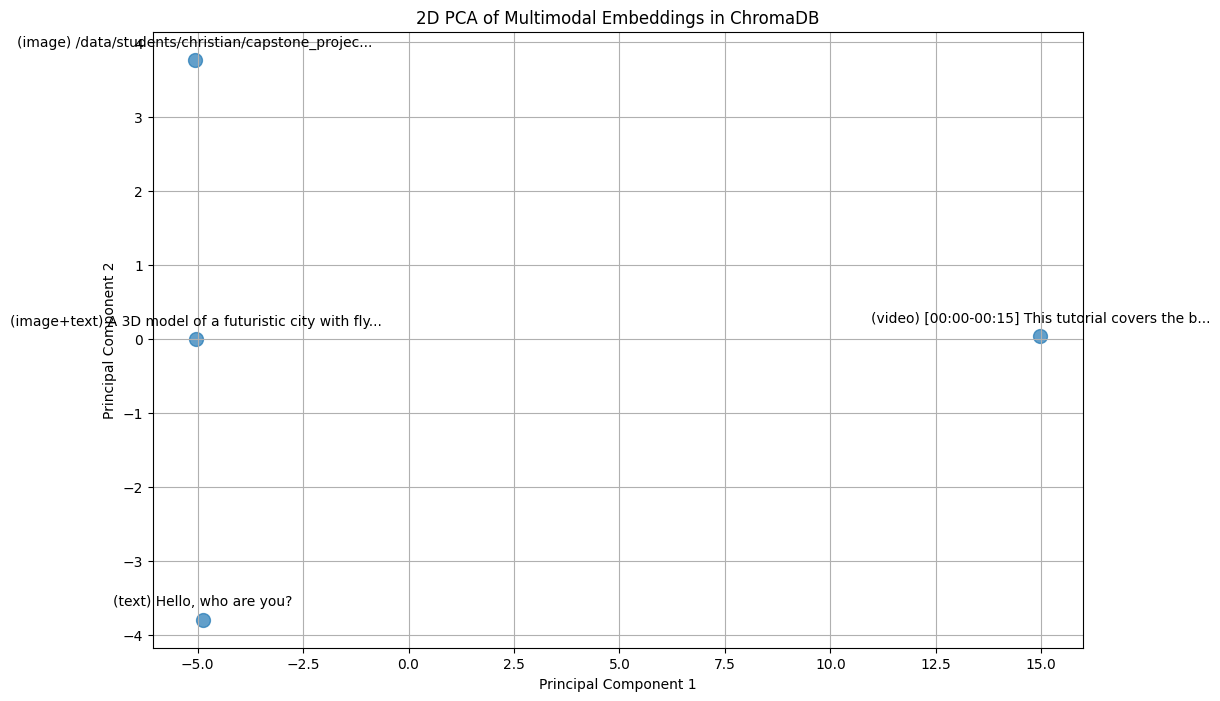

In [26]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Get all items from the collection, making sure to include embeddings
collection_data = collection.get(include=['embeddings', 'documents', 'metadatas'])

# Check if we have embeddings to plot.
# We use .get('embeddings') which safely returns None if the key is missing or the list is empty.
if collection_data.get('embeddings', None) is None:
    print("No embeddings found in the collection. Cannot perform PCA.")
else:
    # 2. Prepare the data for PCA
    embeddings = np.array(collection_data['embeddings'])
    
    # Create descriptive labels for each point using its type and content
    labels = []
    for meta, doc in zip(collection_data['metadatas'], collection_data['documents']):
        # Shorten long document strings for better plot readability
        doc_preview = (doc[:40] + '...') if len(doc) > 40 else doc
        labels.append(f"({meta['type']}) {doc_preview}")

    # 3. Perform PCA
    # Reduce the 3584-dimensional embeddings to 2 dimensions
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)

    # 4. Create the plot
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7, s=100)
    
    # Add labels to each point
    for i, label in enumerate(labels):
        plt.annotate(label, 
                     (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                     textcoords="offset points",
                     xytext=(0,10),
                     ha='center')

    plt.title('2D PCA of Multimodal Embeddings in ChromaDB')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()

In [25]:
collection_data["embeddings"].shape

(4, 3584)

In [ ]:
### TEXT DATA (compare traditional pdf parsing vs llm-based parsing)

In [ ]:
### UNSTRUCTURED DATA (PDF)

import fitz  # PyMuPDF
from PIL import Image
import io

# Assume encode_text and encode_image functions are defined elsewhere
# from embedder import encode_text, encode_image

def process_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text_embeddings = []
    image_embeddings = []

    full_text = ""
    for page in doc:
        # 1. Extract text from the page
        full_text += page.get_text()

        # 2. Extract images from the page
        for img_index, img in enumerate(page.get_images(full=True)):
            xref = img[0]
            base_image = doc.extract_image(xref)
            image_bytes = base_image["image"]
            
            # Convert to PIL Image and get embedding
            image = Image.open(io.BytesIO(image_bytes))
            # For demonstration, let's pretend we save and reload
            # In a real scenario, you'd pass the PIL image object
            # to a modified encode_image function.
            # image_embedding = encode_image(image) 
            # image_embeddings.append(image_embedding)


    # 3. Get a single embedding for all text in the PDF
    if full_text:
        # text_embedding = encode_text(full_text)
        # text_embeddings.append(text_embedding)
        print("Extracted text is ready for embedding.")


    print(f"PDF processed. Found text and {len(image_embeddings)} images.")
    # return text_embeddings, image_embeddings

# Example usage:
# process_pdf("my_document.pdf")

In [ ]:
### TABULAR DATA


In [ ]:
### AUDIO DATA

In [ ]:
### IMAGE DATA  

In [ ]:
### CHROMADB SETUP


In [ ]:
# use chromadb???


# categorize/cluster the videos based on their content, and then use these clusters to improve retrieval efficiency.
# per video, divide into chapters, then chunks, so there's a caption per chunk, summarizing that part, for better retrieval

# what if for these parts, use gemini 2.5 pro thinking to caption and add relevant metadata, so later down the line, the retrieval is more efficient?
    # and also for text docus and images, use the same approach?

    # but this is just supplementary, you can still use other methods to parse the text, images, and videos, and then use this metadata to improve retrieval

# how to store this metadata + text, audio, video embeddings in a vector database?
# how do i improve retrieval efficiency?
#

In [ ]:
### (OPTIONAL) Graph Construction/Generation

# Different RAG Setups

## Traditional/Static RAG


In [ ]:
### GENERATION MODEL


In [ ]:
### SAMPLE QUERY


In [ ]:
# w/ reranking


## Agentic Multimodal RAG with Reasoning

## Hyper-RAG (replicated from https://arxiv.org/pdf/2504.08758)

## AI-University Architecture (replicated from https://arxiv.org/pdf/2504.08846)

# Benchmarking Model

- use benchmarks online and compare the architectures
- compare per model inference time, quality, etc


ex. 

- BEIR
- MS MARCO
- TREC
- MuSiQue
- 2WikiMultihopQA
- AgentG
- HotpotQA
- RAGBench
- BERGEN
- FlashRAG Toolkit
- GNN-RAG


multimodal RAG benchmarks?
- MRAG-Bench
- MRAMG-Bench
- zhzhen23/DynVQA
- https://github.com/JarvisUSTC/Awesome-Multimodal-RAG

create own benchmark based on own data
- https://huggingface.co/learn/cookbook/en/rag_evaluation


from https://huggingface.co/blog/vlms-2025
- MMT-Bench
- MMMU-Pro

# App Frontend

In [ ]:
# (optional) allow enabling of thinking mode?


# for video details, include duration, fps, resolution, file size

# Model Serving

In [ ]:
#

# (Optional/Future Work) Jailbreak Security

# (Optional/Future Work) Logging User Chat History